In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, InputLayer, Flatten, BatchNormalization, Layer, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model
import tensorflow_probability as tfp

In [40]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True)

In [41]:
# Creating a function for dataset split
def dataset_split(dataset, train_ratio, test_ratio, val_ratio):
  '''
  This function use to split dataset into train, test and validation dataset.
  And it's returns train, test, validation datasets.
  Arg:
    dataset: the dataset you have.
    train ratio: train dataset ratio between 0-1 where 1 represent 100%.
    test ratio: test dataset ratio 0-1.
    val_ration: validation data ratio 0-1.

  '''
  #main_dataset
  #print(list(dataset.as_numpy_iterator()))
  dataset_size = len(dataset)

  # for training dataset
  train_dataset = dataset.take(int(dataset_size*train_ratio))
  #print(list(train_dataset.as_numpy_iterator()))

  # for test dataset
  test_dataset_list = dataset.skip(int(dataset_size * train_ratio))
  test_dataset = test_dataset_list.take(int(dataset_size * test_ratio))
  #print(list(test_dataset_list.as_numpy_iterator()))
  #print(list(test_dataset.as_numpy_iterator()))

  # For validation dataset
  val_dataset = test_dataset_list.skip(int(dataset_size * test_ratio))
  #print(list(val_dataset.as_numpy_iterator()))

  return train_dataset, test_dataset, val_dataset

In [42]:
# Calling the dataset_split function
train_dataset, test_dataset, val_dataset = dataset_split(dataset['train'], train_ratio=.7, test_ratio=.15, val_ratio=.15)

In [43]:
for data in train_dataset.take(2):
  print(data)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(133, 127, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [44]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

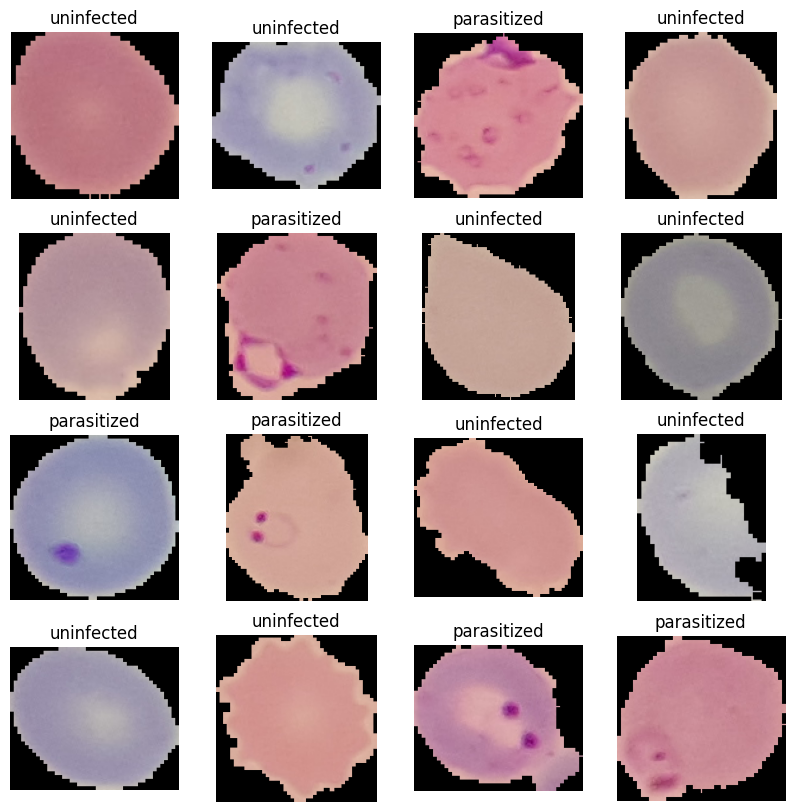

In [45]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [46]:
img_size = 224
# creating a function for resize and rescale dataset
def resize_rescale(image, label):
  return tf.image.resize(image, (img_size, img_size))/255.0, label

In [47]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.Conv2D_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_1 = BatchNormalization()
    self.MaxPool2D_1 =  MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.Conv2D_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_normalization_2 = BatchNormalization()
    self.MaxPool2D_2 =  MaxPool2D(pool_size=pool_size, strides=2*strides)


  def call(self, x):
    x = self.Conv2D_1(x)
    x = self.batch_normalization_1(x)
    x = self.MaxPool2D_1(x)

    x = self.Conv2D_2(x)
    x = self.batch_normalization_2(x)
    x = self.MaxPool2D_2(x)
    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)


In [48]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
    self.flatten = Flatten()
    self.dense_1 = Dense(100, activation = 'relu')
    self.batch = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu')
    self.batch_2 = BatchNormalization()
    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_subclass_model = LenetModel()
lenet_subclass_model(tf.zeros([1, 224, 224, 3]))
lenet_subclass_model.summary()

Model: "lenet_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_9 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_7 (Flatten)         multiple                  0         
                                                                 
 dense_21 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_34 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_35 (Ba  multiple                

Custom Loss

In [49]:
def custom_bce(FACTOR):
  def t_loss(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * FACTOR

  return t_loss

In [50]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR

  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) * FACTOR


Custom Accuracy

In [51]:
from tensorflow.keras.metrics import binary_accuracy
def custom_accuracy(FACTOR=100):
  def metric(y_true, y_pred):
    return binary_accuracy(y_true, y_pred) * FACTOR
  return metric

In [59]:
class Custom_Accuracy(tf.keras.metrics.Metric):
  def __init__(self, name = 'custom_accuracy', FACTOR = 100):
    super(Custom_Accuracy, self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name=name, initializer = 'zeros')

  def update_state(self, y_true, y_pred, sample_weight = None):
    output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
    self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype=tf.float32))

  def result(self):
    return self.accuracy

  def reset_state(self):
    return self.accuracy.assign(0.)

In [53]:
# Compile the model
FACTOR = 1
lennet_model = LenetModel()
lennet_model.compile(
    optimizer = Adam(),
    loss = CustomBCE(FACTOR),
    metrics = Custom_Accuracy()
)

In [54]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

In [55]:
BATCH_SIZE = 32

In [56]:
train_dataset = (train_dataset
                 .shuffle(buffer_size=1024, )
                 .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [57]:
val_dataset = (val_dataset
               #.shuffle(buffer_size=4096, )
               .map(resize_rescale, num_parallel_calls=tf.data.AUTOTUNE)
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [60]:
lennet_model_experiment = lennet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 5
)

Epoch 1/5
603/603 [==============================] - 46s 75ms/step - loss: 0.1835 - custom__accuracy_3: 0.9615 - val_loss: 0.3702 - val_custom__accuracy_3: 0.8571
Epoch 2/5
603/603 [==============================] - 41s 67ms/step - loss: 0.1507 - custom__accuracy_3: 0.9615 - val_loss: 0.3279 - val_custom__accuracy_3: 0.8571
Epoch 3/5
603/603 [==============================] - 45s 75ms/step - loss: 0.1319 - custom__accuracy_3: 0.9615 - val_loss: 0.3284 - val_custom__accuracy_3: 0.8571
Epoch 4/5
603/603 [==============================] - 45s 74ms/step - loss: 0.1083 - custom__accuracy_3: 1.0000 - val_loss: 0.4864 - val_custom__accuracy_3: 0.8571
Epoch 5/5
603/603 [==============================] - 39s 64ms/step - loss: 0.0940 - custom__accuracy_3: 0.8846 - val_loss: 0.3618 - val_custom__accuracy_3: 1.0000


<Axes: >

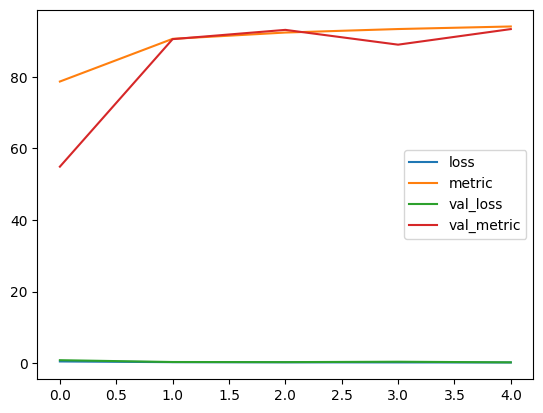

In [20]:
import pandas as pd
pd.DataFrame(lennet_model_experiment.history).plot()